# Advanced dimensionality reduction 
##### By : Jash Chalodiya

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.io import arff
from matplotlib.colors import Normalize
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler

# Task 1

In [50]:
# Loading the dataset
data, meta = arff.loadarff("dataset.arff")
df = pd.DataFrame(data)

for col in df.columns:
    if df[col].dtype == object and isinstance(df[col].iloc[0], bytes):
        df[col] = df[col].str.decode('utf-8')

print("Shape:", df.shape)
print(df.head())

Shape: (17379, 15)
   season  year  month  hour holiday  weekday workingday weather  temp  \
0  spring   0.0    1.0   0.0   False      6.0      False   clear  9.84   
1  spring   0.0    1.0   1.0   False      6.0      False   clear  9.02   
2  spring   0.0    1.0   2.0   False      6.0      False   clear  9.02   
3  spring   0.0    1.0   3.0   False      6.0      False   clear  9.84   
4  spring   0.0    1.0   4.0   False      6.0      False   clear  9.84   

   feel_temp  humidity  windspeed  casual  registered  count  
0     14.395      0.81        0.0     3.0        13.0   16.0  
1     13.635      0.80        0.0     8.0        32.0   40.0  
2     13.635      0.80        0.0     5.0        27.0   32.0  
3     14.395      0.75        0.0     3.0        10.0   13.0  
4     14.395      0.75        0.0     0.0         1.0    1.0  


In [51]:
# Separating features and target
target_col = 'cnt' if 'cnt' in df.columns else df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col].astype(float)

# Encoding categorical features
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Standardizing numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PCA (linear)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE (non-linear)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

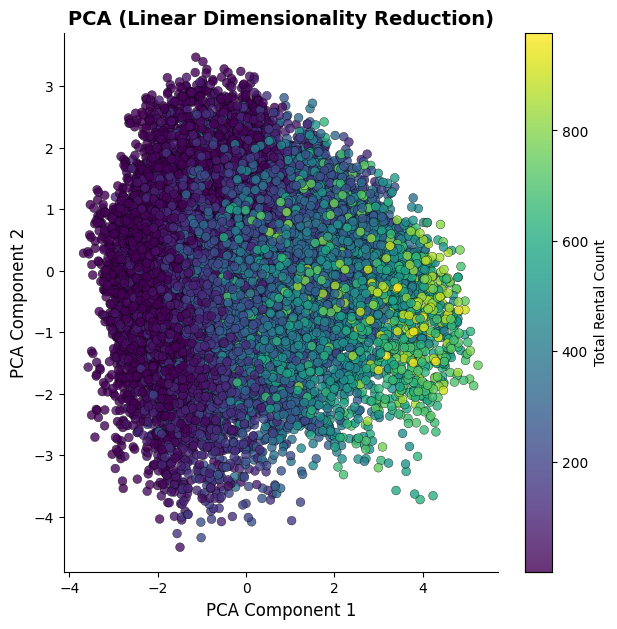

In [53]:
# Visualization
plt.figure(figsize=(7, 7))
norm = Normalize(vmin=y.min(), vmax=y.max())
cmap = plt.cm.viridis

# PCA plot
sc_pca = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y, cmap=cmap, norm=norm,
    s=40, alpha=0.8, edgecolor='k', linewidth=0.3
)
plt.colorbar(sc_pca, label='Total Rental Count')
plt.title('PCA (Linear Dimensionality Reduction)', fontsize=14, fontweight='bold')
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
sns.despine()

#### The above scatter plot is showing a gradual color gradient in rental counts along the first principal component, which indicates that the bike usage increases gradually with favorable weather and seasonal conditions. However there is some overlap between data points, which suggests that the relationship between features and rental demand is not entirely linear. Overall, PCA is efficiently highlighting the dominant linear trends in the dataset but is less capable for capturing the complex, non-linear dependencies influencing bike rentals.

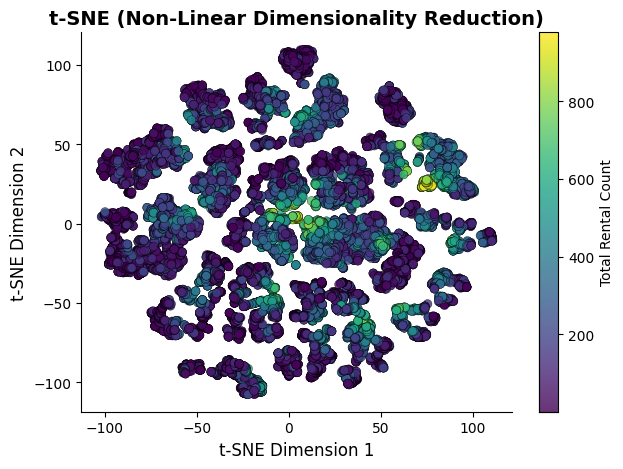

In [54]:
# t-SNE plot
sc_tsne = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=y, cmap=cmap, norm=norm,
    s=40, alpha=0.8, edgecolor='k', linewidth=0.3
)
plt.colorbar(sc_tsne, label='Total Rental Count')
plt.title('t-SNE (Non-Linear Dimensionality Reduction)', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
sns.despine()

plt.tight_layout()
plt.show()

#### Unlike the smoother, continuous structure we saw in PCA, the t-SNE plot is showcasing distinct clusters of data points that is corresponding to different usage patterns, most likely because of combinations of season, temperature and weather condiions. This shows that t-SNE successfully captured the complex, non-linear interactions among the features that influenced bike rental pattern. Overall, t-SNE offered a more useful view of hidden structures in the data, which showed that rental demand patterns are influenced by multiple interacting factors rather than by simple linear relationships.

In [55]:
# Fitting PCA only on training data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


# Model evaluation function
def evaluate_model(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return {
        "R2": r2_score(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": mean_squared_error(y_test, preds, squared=False)
    }

# Splitting original data
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# All features
metrics_full = evaluate_model(X_train, X_test, y_train, y_test)

# PCA features
metrics_pca = evaluate_model(X_train_pca, X_test_pca, y_train, y_test)

# t-SNE features
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(X_tsne, y, test_size=0.2, random_state=42)
metrics_tsne = evaluate_model(X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne)

# Performance comparison
results = pd.DataFrame([metrics_full, metrics_pca, metrics_tsne],
                       index=['Original', 'PCA', 't-SNE'])
print("\nModel Performance Comparison:")
print(results.round(4))


/Users/jashchalodiya/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/jashchalodiya/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Model Performance Comparison:
              R2      MAE     RMSE
Original  0.9998   0.9482   2.7393
PCA       0.9998   1.1374   2.4741
t-SNE     0.9356  32.8191  45.1481


/Users/jashchalodiya/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### The Random Forest trained on the original feature achieved near perfect results with R2 = 0.9998, RMSE = 2.73, which confirms that the complete feature space conrtains rich predictive information. However, the PCA reduced dataset also produced almost identical results with R2 = 0.9998, RMSE = 2.4741, which showed that PCA efficiently retained the key linear relationships between features. Whereas, the t-SNE reduced features resulted in lower accuracy, most likely due to t-SNE focus on preserving local structure rather than global predictive relationships. Overall, these results showed that PCA can significantly reduce dimensionality without compromising model performance, while t-SNE is more suited for visualization.

# Task 2

In [56]:
# Loading the dataset
data, meta = arff.loadarff("mnist_784.arff")
df = pd.DataFrame(data)

for col in df.columns:
    if df[col].dtype == object and isinstance(df[col].iloc[0], bytes):
        df[col] = df[col].str.decode("utf-8")

# Separating features and target
X = df.drop(columns=["class"])
y = df["class"].astype(int)

In [57]:
# Normalizing the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Data shape:", X_scaled.shape)

Data shape: (70000, 784)


In [58]:
# Training SOM
som_grid = (20, 20)
som = MiniSom(x=som_grid[0], y=som_grid[1], input_len=X_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_scaled)
som.train_random(X_scaled, num_iteration=10000, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 4.946670001777804


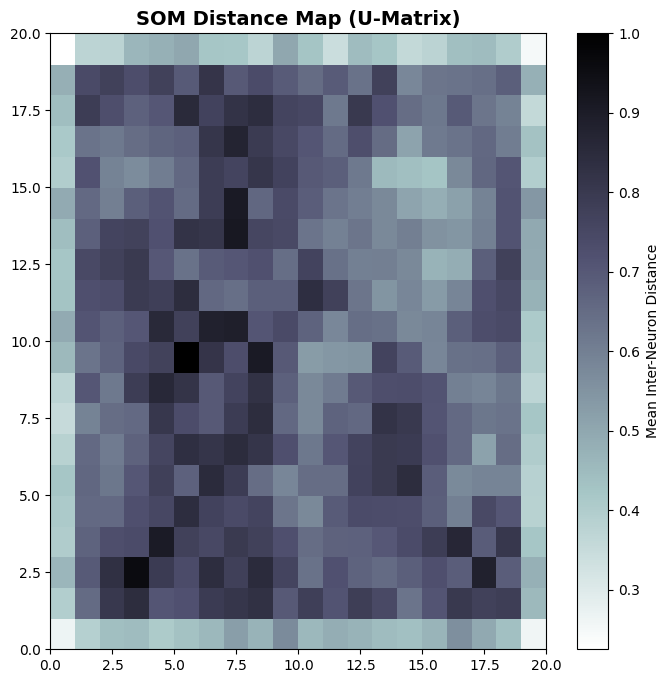

In [59]:
# U-Matrix (distance map)
plt.figure(figsize=(8, 8))
plt.title("SOM Distance Map (U-Matrix)", fontsize=14, fontweight='bold')
u_matrix = som.distance_map().T
plt.pcolor(u_matrix, cmap='bone_r')
plt.colorbar(label='Mean Inter-Neuron Distance')
plt.show()

#### In the above plot light colored regions represent cluster of neurons that responds to similar digit paterns, while darker areas mark the boundaries between different digit groups. This indicates that the SOM has successfully learned the structure of the data, hence placed visually similar digits close to each other. The gradual color changes within the clusters also reflects variation in handwriting styles for the same digit. Overall, the U-Matrix helped in understanding, how the SOM organizes complex, high dimensional data into an interpretable two dimensional layout.

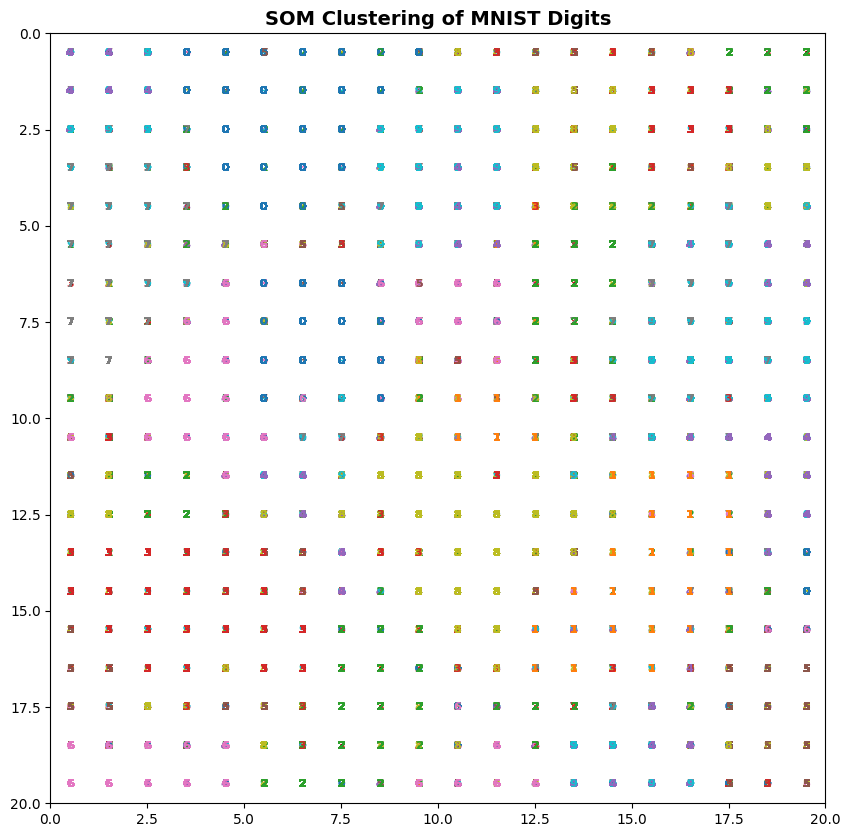

In [60]:
# Digit label map
plt.figure(figsize=(10, 10))
plt.title("SOM Clustering of MNIST Digits", fontsize=14, fontweight='bold')

# Assigning each sample to the nearest SOM node
for i, x in enumerate(X_scaled):
    w = som.winner(x)
    plt.text(
        w[0] + 0.5,
        w[1] + 0.5,
        str(y.iloc[i]),
        color=plt.cm.tab10(y.iloc[i] / 10),
        fontdict={'weight': 'bold', 'size': 8},
        ha='center', va='center'
    )

plt.xlim([0, som_grid[0]])
plt.ylim([0, som_grid[1]])
plt.gca().invert_yaxis()
plt.show()

#### In the above plot each cell is showing the most common digit assigned to that neuron, which helps in seeing where specific digit classes are located and how they are realated to one another. Clusters of the same label are indicating regions where the SOM consistently recognized similar digit patterns, while neighboring labels are showing similarities between digits with comparable shapes, such as '3' and '8'. It is not only showing boundaries between clusters but also which region is occupied by which digit. Overall, the digit label map helped in understanding, how the SOM organized and classified the digits based on their visual and structura similarities. 